In [1]:
import os
import numpy as np
import torch as pt
import matplotlib.pyplot as plt
from tqdm import tqdm
from glob import glob
from matplotlib import rcParams

import src as sp
import runtime as rt
from theme import colors

# font parameters
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
rcParams['font.size'] = 12

In [2]:
# parameters
device = pt.device("cpu")
min_id = True 
min_sim = False 
r_noise = 0.0
n_sample = 1

# locate filepaths
pdb_filepath = "examples/2oob.pdb"

# output path
output_path = "examples"

# model parameters
# r6
save_path = "model/save/s_v6_4_2022-09-16_11-51"  # virtual Cb & partial
#save_path = "model/save/s_v6_5_2022-09-16_11-52"  # virtual Cb, partial & noise

# r7
#save_path = "model/save/s_v7_0_2023-04-25"  # partial chain
#save_path = "model/save/s_v7_1_2023-04-25"  # partial secondary structure
#save_path = "model/save/s_v7_2_2023-04-25"  # partial chain high coverage

# create runtime model 
model = rt.SequenceModel(save_path, "model.pt", device=device)

# create confidence mapping
conf = rt.ConfidenceMap("results/{}_cdf.csv".format(os.path.basename(save_path)))

In [3]:
# load structure
structure = rt.load_structure(pdb_filepath)

# find all chains
cids = [cid.split(':')[0] for cid in np.unique(structure['chain_name'])]

# design one chain at a time
for cid in cids:
    # known chains
    m_known = ~np.isin([cn.split(':')[0] for cn in structure['chain_name']], [cid])

    # apply noise
    r = pt.randn((structure['xyz'].shape[0], n_sample, structure['xyz'].shape[1])).numpy()
    structure['xyz'] = np.expand_dims(structure['xyz'],1) + r_noise * r
    
    # apply model
    structure, P, y = model(structure, m_known=m_known)

    # get highest average confidence prediction
    if len(P.shape) > 2:
        C = np.stack([conf(P[i].numpy()) for i in range(P.shape[0])])
        iopt = np.argmax(np.mean(np.max(C, axis=2), axis=1))
        p = P[iopt]
    else:
        p = P

    # amino acid only
    p, y = rt.aa_only(p, y)
    
    # find residues per chain and known residues
    mr_chains, chain_names = rt.chain_masks(structure)
    mr_known = pt.any(mr_chains[:,pt.from_numpy(~np.isin(chain_names, [cid]))], dim=1)
    
    # overwrite prediction
    p[mr_known] = y[mr_known]
    
    if min_id:
        # minimize sequence identity
        m_choice = (pt.sum(pt.round(p), dim=1) > 1.0)
        p[m_choice, pt.argmax(y, dim=1)[m_choice]] = 0.0

    # get sequence
    if min_sim:
        seqs = [rt.minimize_sequence_similarity(p[mr_chains[:,i]], y[mr_chains[:,i]])[0] for i in range(mr_chains.shape[1])]
    else:
        seqs = [rt.max_pred_to_seq(p[mr_chains[:,i]]) for i in range(mr_chains.shape[1])]

    # subunits ids
    sid = os.path.basename(pdb_filepath).split('.')[0]
    
    # write fasta
    rt.write_fasta(os.path.join(output_path, "{}.fasta".format(sid)), ':'.join(seqs), info=os.path.basename(save_path))

    # store processed input structure
    structure['xyz'] = structure['xyz'][:,0]
    sp.save_pdb(sp.split_by_chain(structure), pdb_filepath[:-4]+"_bb.pdb")
    
    # debug
    print("{}, {:.3f}".format(sid, rt.recovery_rate(y, p)))

2oob, 0.569


In [4]:
plt.figure()
plt.imshow
p.numpy()

array([[1.6557662e-05, 6.6070847e-06, 8.8731313e-06, ..., 1.0002410e-06,
        9.9989450e-01, 1.1719677e-03],
       [3.9891093e-03, 2.1650828e-01, 1.6383120e-01, ..., 1.0383289e-03,
        8.2190681e-01, 2.8817778e-02],
       [1.6450525e-05, 1.9812245e-09, 5.9724414e-10, ..., 1.9969909e-10,
        6.6288776e-05, 8.8716231e-05],
       ...,
       [3.8592119e-02, 8.6229318e-01, 5.4685014e-01, ..., 2.3258489e-02,
        3.5696205e-01, 7.1456730e-02],
       [0.0000000e+00, 3.2960609e-02, 2.3056610e-02, ..., 4.0230895e-03,
        1.5380198e-01, 1.2384006e-02],
       [2.3346663e-01, 3.2726370e-02, 0.0000000e+00, ..., 1.5756104e-03,
        1.3237478e-01, 2.1464434e-01]], dtype=float32)

<Figure size 640x480 with 0 Axes>

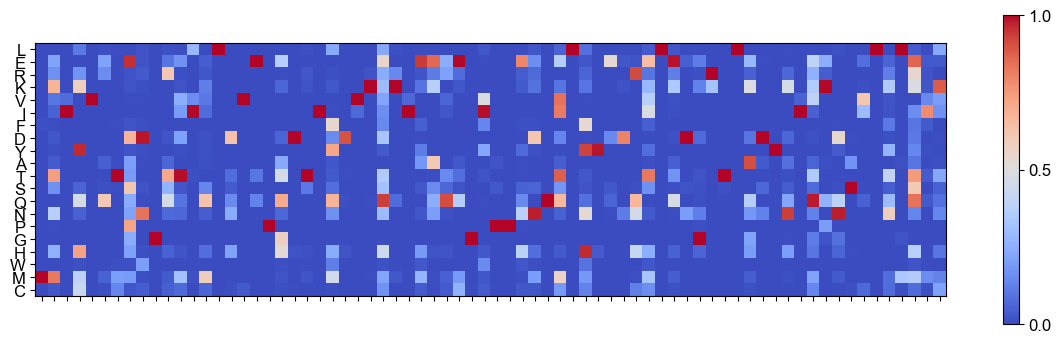

In [23]:
# get residue numbering
resids = structure['resid'][structure['name'] == 'CA']

# plot
plt.figure(figsize=(12,3.6))
plt.imshow(p.numpy().T, cmap='coolwarm', vmin=0.0, vmax=1.0)
#plt.xticks(np.arange(p.shape[0])[::1], resids[::1])
plt.xticks(np.arange(p.shape[0])[::1], '')
plt.yticks(np.arange(20), [sp.res3to1[r] for r in sp.std_resnames[:20]], ha='right')
cbar = plt.colorbar(ticks=[0.0, 0.5, 1.0])
#plt.xlabel('amino acid position')
#plt.ylabel('predicted amino-acid')
#plt.title('prediction confidence')
plt.tight_layout()
plt.savefig("graphs/illustration_confidence.svg")
plt.show()